In [16]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# model summary info
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_60529/3559585180.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Gaussian blurs with varying widths and occluding bars

This code segment is designed to generate a dataset of synthetic images, each depicting a Gaussian distribution with a unique width and a random bar overlaid on the distribution. The goal is to create a varied set of images for tasks such as pattern recognition or machine learning model training. Here's an overview of the process and key components:

- **Parameter Setup**: The code initializes variables for the number of Gaussian images (`nGauss`) to generate and the size of each image (`imgSize`). A spatial grid is created using `np.meshgrid`, spanning from -4 to 4 in both dimensions, to serve as the basis for the Gaussian distributions.

- **Varying Gaussian Widths**: The `widths` array, created with `np.linspace`, provides a range of values for the standard deviation of the Gaussians. This variation ensures each generated image has a distinct Gaussian blob with a unique spread.

- **Image Tensor Initialization**: A tensor `images` is initialized to hold the generated images, with dimensions corresponding to the number of Gaussians, the number of color channels (1, indicating grayscale), and the image dimensions.

- **Gaussian Generation and Augmentation**:
  - For each Gaussian image, a random offset (`ro`) determines the center of the Gaussian blob, introducing variability in the placement of Gaussians across the images.
  - Gaussian noise is added to each image to simulate real-world imperfections and increase the dataset's complexity.
  - A "bar" (a line of pixels set to maximum intensity) is randomly added either horizontally or vertically to each image. The position and size of the bar are randomly determined, further augmenting the dataset with structural variations.

- **Tensor Population**: Each generated image, represented as a 2D array, is added to the `images` tensor. This structured approach facilitates the use of the dataset in machine learning frameworks that operate on tensors, such as PyTorch.

The creation of this synthetic dataset with varied Gaussian blobs and additional structural features (bars) provides a rich set of images for exploring image processing techniques, pattern recognition algorithms, and neural network training, offering a controlled environment to study the effects of image variations on model performance.


In [17]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss)

# initialize tensor containing images
images = torch.zeros(nGauss,1,imgSize,imgSize)

for i in range(nGauss):

  # create the gaussian with random centers
  ro = 1.5*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1
  else:
    G[:,i1:i1+i2] = 1

  # min-max normalize the image
  g_min = np.min(G)
  g_max = np.max(G)
  G = (G - g_min) / (g_max - g_min)
    
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

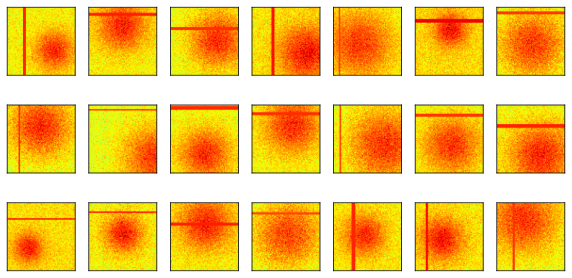

In [18]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create the DL model

In [19]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2,2),
          nn.Conv2d(6,4,3,padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2,2)  
          )
      
      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(4,6,3,2),
          nn.ReLU(),
          nn.ConvTranspose2d(6,1,3,2),
          )
      
    def forward(self,x):
      return self.dec( self.enc(x) )
  
  # create the model instance
  net = gausnet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

 
torch.Size([10, 1, 91, 91])


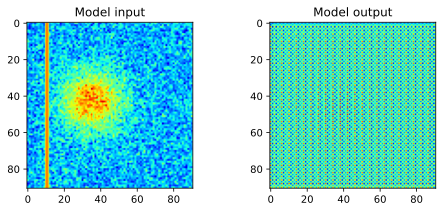

In [20]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

yHat = net(images[:10,:,:,:])

# check size of output
print(' ')
print(yHat.shape)

# let's see how they look
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(torch.squeeze(images[0,0,:,:]).detach(),cmap='jet')
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat[0,0,:,:]).detach(),cmap='jet')
ax[1].set_title('Model output')

plt.show()

In [21]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
   ConvTranspose2d-7            [-1, 6, 45, 45]             222
              ReLU-8            [-1, 6, 45, 45]               0
   ConvTranspose2d-9            [-1, 1, 91, 91]              55
Total params: 557
Trainable params: 557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.24
Params size (MB): 0.00
Estimated Total Size (MB): 1.27
---------------------------------------------------

# Create a function that trains the model

In [22]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 500
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # pick a set of images at random
    pics2use = np.random.choice(nGauss,size=32,replace=False)
    X = images[pics2use,:,:,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

In [23]:
# test the model on a bit of data
losses,net = function2trainTheModel()

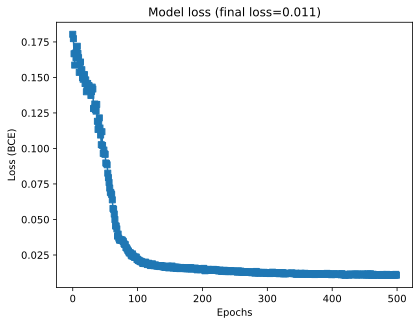

In [24]:
plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (BCE)')
plt.title('Model loss (final loss=%.3f)'%losses[-1])

plt.show()

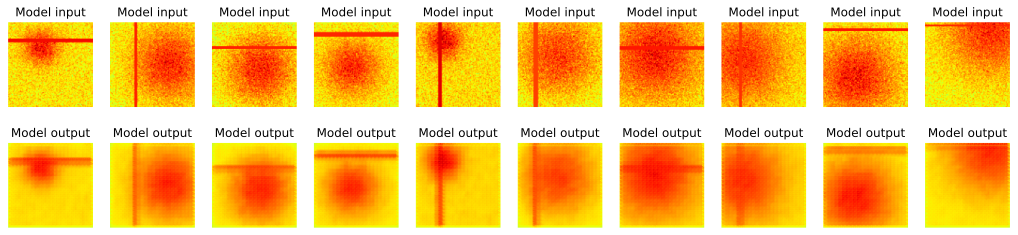

In [25]:
# visualize some images

pics2use = np.random.choice(nGauss,size=32,replace=False)
X = images[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10):
  
  G = torch.squeeze( X[i,0,:,:] ).detach()
  O = torch.squeeze( yHat[i,0,:,:] ).detach()
  
  axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title('Model input')

  axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title('Model output')

plt.show()

## Additional explorations

In [26]:
# 1) There are no test data here, so how do you know whether the model overfit the training set? Fortunately, you can
#    simply create as much new data as you want! That's one of the advantages of generating data ;)
#    Generate a new dataset to use as a test set. How does the MSE loss compare on the test set? Did we overfit here?
# 
# 2) The code here uses MaxPool. Are the results noticeably different if you use AvgPool instead?
# 
# 3) The final output doesn't have a nonlinearity (e.g., relu, sigmoid, tanh). Does it need one? Would that help? What
#    are some arguments for and against having a nonlinear activation function on the output of the decover? Try adding
#    one and see if it improves (via the final loss and visual inspection) the result.
# 
# 4) I mentioned in the lecture "What are autoencoders and what do they do?" (section "Autoencoders") that BCEloss can be
#    used when the data are between 0 and 1. Normalize the images so they are appropriately scaled, and then use BCEloss
#    instead of MSEloss (does anything else in the model architecture need to change?). Which loss function gives a 
#    better result?
# 

In [27]:
test_dataset_size = 500
imgSize = 91

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)

# vary the widths smoothly
widths = np.linspace(2, 20, test_dataset_size)

# initialize tensor containing images
test_dataset = torch.zeros(test_dataset_size, 1, imgSize, imgSize)

for i in range(test_dataset_size):
    # create the gaussian with random centers
    ro = 1.5 * np.random.randn(2)  # ro = random offset
    G = np.exp(- ((X - ro[0]) ** 2 + (Y - ro[1]) ** 2) / widths[i])

    # and add noise
    G = G + np.random.randn(imgSize, imgSize) / 5

    # add a random bar randomly
    i1 = np.random.choice(np.arange(2, 28))
    i2 = np.random.choice(np.arange(2, 6))
    if np.random.randn() > 0:
        G[i1:i1 + i2, :] = 1
    else:
        G[:, i1:i1 + i2] = 1

    # min-max normalize the image
    g_min = np.min(G)
    g_max = np.max(G)
    G = (G - g_min) / (g_max - g_min)
    
    # add to the tensor
    test_dataset[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)

In [28]:
yHat = net(test_dataset)
lossfun = nn.MSELoss()
loss = lossfun(yHat,test_dataset)

In [29]:
loss

tensor(0.0109, grad_fn=<MseLossBackward0>)

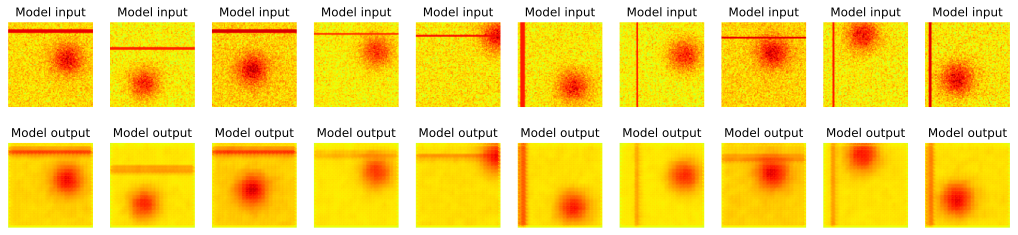

In [30]:
fig,axs = plt.subplots(2,10,figsize=(18,4))

for i in range(10):
  
  G = torch.squeeze( test_dataset[i,0,:,:] ).detach()
  O = torch.squeeze( yHat[i,0,:,:] ).detach()
  
  axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title('Model input')

  axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title('Model output')

plt.show()